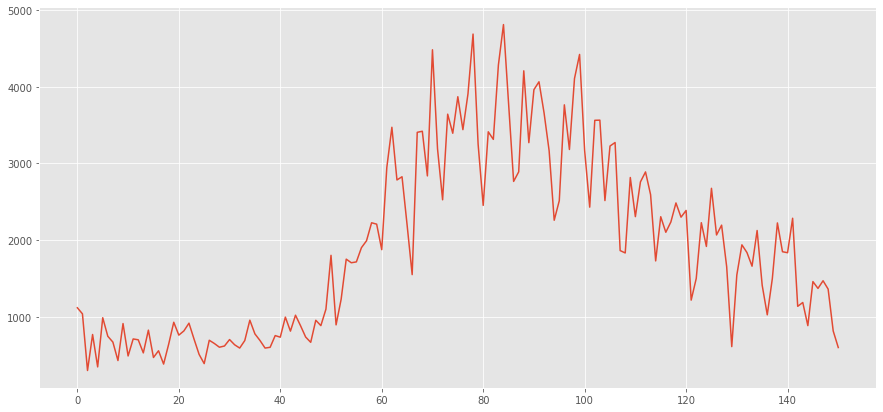

In [1]:
import pandas as pd
import numpy as np
import re
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit, least_squares, leastsq, fmin

from datetime import datetime

# Below, we load the data.

%matplotlib inline
plt.style.use('ggplot')

def convertDate(theDate):
    date_format = "%Y-%m-%d"
    start = "2020-05-01"
    a = datetime.strptime(start, "%Y-%m-%d")
    b = datetime.strptime(theDate, "%Y-%m-%d")
    delta = b-a
    return (int(delta.days))
    
gdaData = pd.read_csv('ctp_state_data.tsv',sep='\t')
state = gdaData[gdaData['state'] == "GA"]
state = state[['date', 'daily_cases', 'cumsum_cases']]
state['cumsum_cases'] = state['cumsum_cases'] - state['cumsum_cases'][ state.first_valid_index() ]
state['date'] = state['date'].apply(convertDate)
state = state[state['date'] <= 150]

# weeks = []
# weekly_cases = []
# for i in range( math.floor( len(state) / 7 ) ):
#     weeks.append( i )
#     weekly_cases.append( sum( state['daily_cases'][ i * 7 : ( i + 1 ) * 7 ] ) )

# state = pd.DataFrame( { 'date': weeks, 'daily_cases': weekly_cases } )
    
fig = plt.figure(figsize=(15,7))
plt.plot(state['date'], state['daily_cases'])

In [2]:
# Here, we define the SIR model.

S0 = 40000000
I0 = 20
R0 = 0
r = 10.0
alpha = 10.0

def deriv(y, t, r, alpha):
    S, I, R = y
    N = S + I + R
    dSdt = -r * (S * I)/N
    dIdt = r * (S * I)/N - alpha * I
    dRdt = alpha * I
    return dSdt, dIdt, dRdt

y0 = S0, I0, R0

tmin = 0
tmax = 150
t = list(range(tmin, tmax))

[10.32430815 10.27824172] 1.0044819368325184 755090792.738339


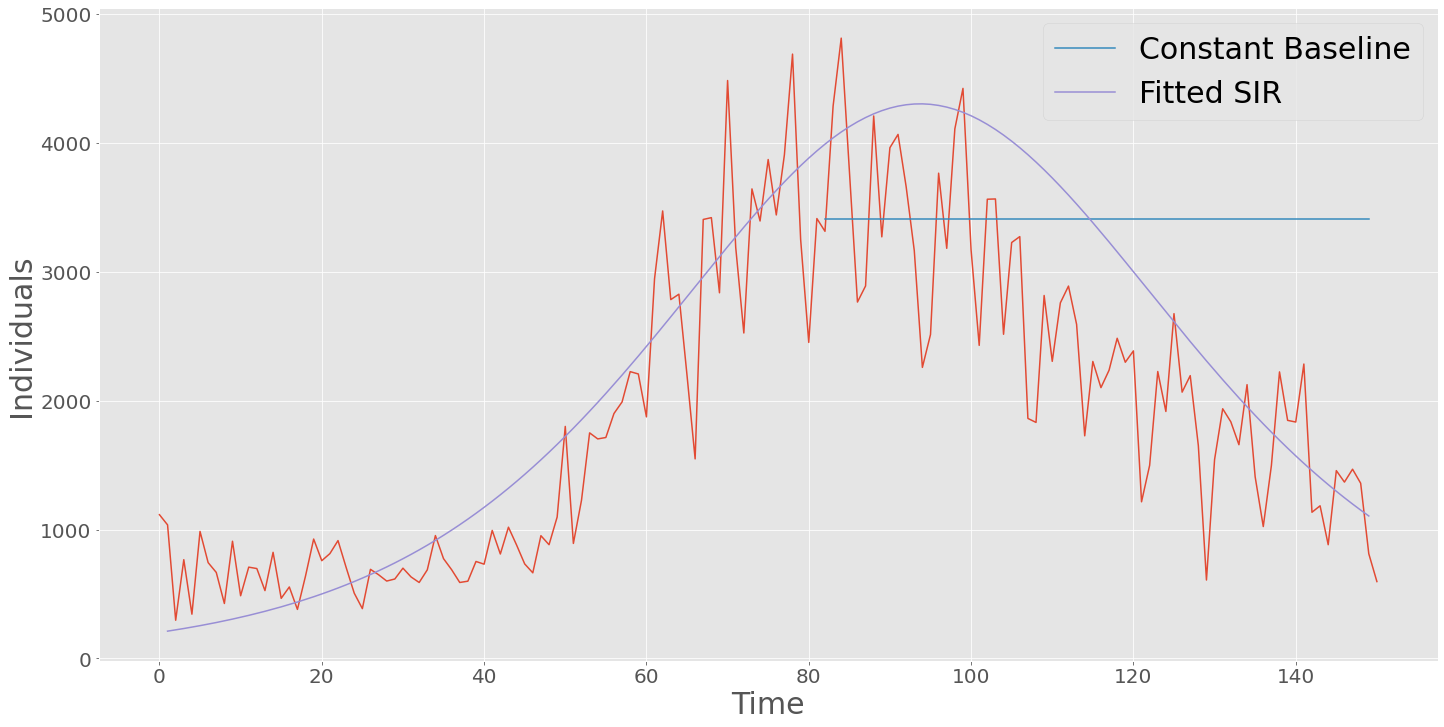

In [3]:
# Here, we fit the SIR model, and plot the results, along with forecasts from the Constant model.
# It is also optionally possible to plot forecasts from the Linear model and the COVIDhub-ensemble model, by uncommenting appropriate lines below.

from scipy.optimize import minimize, curve_fit, least_squares, leastsq, fmin

data_proportion = 0.55

def ls_func(t, params):
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, t, args=tuple(params))
    return ret[:,1] + ret[:,2]

def residual(params):
    trainT = t[:int(len(t)*data_proportion)]
    return (state['cumsum_cases'][1:int(len(t)*data_proportion)] - ls_func(trainT[1:], params))

guess = [r, alpha]

tup = least_squares(residual, guess)#, bounds=(4, 7))

# To determine optimal-ish values of S0 and I0, uncomment the code below, and use it instead of the line above.
# It should provide S0 = 38500000 and I0 = 18; we rounded these to 40000000 and 20.

# best_tup = None
# best_pop = None
# best_inf = None

# for pop in range( 30000000, 40000000, 100000 ):
#     for inf in range( 10, 20, 1 ):
#         S0 = pop
#         I0 = inf
#         guess = [r, alpha]
#         tup = least_squares(residual, guess)#, bounds=(4, 7))
        
#         if best_tup is None or tup.cost < best_tup.cost:
#             best_tup = tup
#             best_pop = pop
#             best_inf = inf

# print( best_pop, best_inf )
            
# tup = best_tup
# S0 = best_pop
# I0 = best_inf

c = tup.x

#popt, pcov = curve_fit(deriv, cases, t)

y0 = S0, I0, R0
ret = odeint(deriv, y0, t, args=tuple(c))
S, I, R = ret.T

forecasted_daily_cases = [ (I+R)[i+1] - (I+R)[i] for i in range( len(t) - 1 ) ]

constant_forecasts = [ state['daily_cases'][ state.first_valid_index() + int(len(t)*data_proportion) - 1 ] ] * ( len(t) - int(len(t)*data_proportion) )
slope = state['daily_cases'][ state.first_valid_index() + int(len(t)*data_proportion) - 1 ] - state['daily_cases'][ state.first_valid_index() + int(len(t)*data_proportion) - 2 ]
linear_forecasts = [ [ state['daily_cases'][ state.first_valid_index() + int(len(t)*data_proportion) - 1 ] ] + slope * ( i + 1 ) for i in range(  len(t) - int(len(t)*data_proportion) ) ]

cdc_forecast_dates = []
cdc_forecasts = []

for forecast_horizon in range(1, 5):
    cdc_forecast = pd.read_csv( 'COVIDhub-ensemble_13_' + str(forecast_horizon) + '.csv' ) # 13 is the location code for Georgia
    cdc_forecast['date'] = cdc_forecast['date'].apply(convertDate)
    cdc_forecast['forecast_date'] = cdc_forecast['forecast_date'].apply(convertDate)
    
    # We obtain the forecast that was made at most recent forecast_date that falls within our training data window (i.e., that is no greater than int(len(t)*data_proportion) - 1).
    cdc_forecast = cdc_forecast.loc[ cdc_forecast['forecast_date'] <= int(len(t)*data_proportion) - 1 ]
    if len( cdc_forecast ) > 0:
#         print( int(len(t)*data_proportion) - 1 )
#         print( cdc_forecast['forecast_date'][ len(cdc_forecast) - 1 ] )
#         print( cdc_forecast['date'][ len(cdc_forecast) - 1 ] )
#         print( cdc_forecast['forecast'][ len(cdc_forecast) - 1 ] )
        cdc_forecast_dates.extend( range( cdc_forecast['date'][ len(cdc_forecast) - 1 ] - 6, cdc_forecast['date'][ len(cdc_forecast) - 1 ] + 1 ) ) # The forecast is made for the week that ends on the given date.
        cdc_forecasts.extend( [ cdc_forecast['forecast'][ len(cdc_forecast) - 1 ] / 7 ] * 7 ) # The forecast provides the number of cases for the week; we divide it evenly across the seven days.    

fig = plt.figure(figsize=(24,12))
plt.plot(state['date'], state['daily_cases'])
plt.plot(t[int(len(t)*data_proportion):], constant_forecasts, label="Constant Baseline")
# plt.plot(t[int(len(t)*data_proportion):], linear_forecasts, label="Linear Baseline")
# plt.plot(cdc_forecast_dates, cdc_forecasts, label="COVIDhub-ensemble")
plt.plot(t[1:], forecasted_daily_cases, label="Fitted SIR")
plt.xlabel("Time", fontsize=30)
plt.ylabel("Individuals", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=30)
print(c, c[0]/c[1], tup.cost)